In [679]:
import pandas as pd
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score

In [680]:
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\breast_cancer')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\breast_cancer'

# Data

## Importing

In [681]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv',low_memory=False)
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [682]:
df.columns[:31] #columns without gene and mutation info

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

### Dropping nan values

In [683]:
#findind nan values
df.isna().sum().sort_values(ascending=False)[:10]

tumor_stage                  501
3-gene_classifier_subtype    204
primary_tumor_laterality     106
neoplasm_histologic_grade     72
cellularity                   54
mutation_count                45
er_status_measured_by_ihc     30
type_of_breast_surgery        22
tumor_size                    20
cancer_type_detailed          15
dtype: int64

In [684]:
#deleting columns with high nans that aren't critical
#del df['3-gene_classifier_subtype']
del df['cellularity']
del df['neoplasm_histologic_grade']
del df['primary_tumor_laterality']
del df['er_status_measured_by_ihc']

In [685]:
#findind nan values
df.isna().sum().sort_values(ascending=False)[:10]

tumor_stage                       501
3-gene_classifier_subtype         204
mutation_count                     45
type_of_breast_surgery             22
tumor_size                         20
cancer_type_detailed               15
tumor_other_histologic_subtype     15
oncotree_code                      15
death_from_cancer                   1
akr1c2                              0
dtype: int64

In [686]:
#dropping nan values 
print(df.shape)
df = df.dropna()
print(df.shape)

(1904, 689)
(1185, 689)


In [687]:
# in cancer_type feature, one instance of Breast Sarcoma was deleted
# feature now only contains one value and is therefore removed 

df.pop('cancer_type');

In [688]:
#we also don't care about patient id 
df.pop('patient_id');

### Encoding data

In [689]:
#encoding binary features 
df = pd.get_dummies(df, columns=['type_of_breast_surgery','er_status','inferred_menopausal_state','pr_status','her2_status'], drop_first=True)

In [690]:
#replace mutant subtypes with wild type (0) or general mutant type (1)
for col in df.columns:
    if 'mut' in col:
        df[col]=np.where((df[col])!='0',1,0)

In [691]:
#removing mutant features with less than 30 positive instances 
for col in df.columns:
    if 'mut' in col:
        if sum(df[col]) < 30:
            del df[col]

In [692]:
#encoding other features
df = pd.get_dummies(df, columns=['3-gene_classifier_subtype','death_from_cancer','cancer_type_detailed','pam50_+_claudin-low_subtype','cohort','integrative_cluster','oncotree_code','her2_status_measured_by_snp6','tumor_other_histologic_subtype'])
df.shape

(1185, 610)

### Removing outliers

In [693]:
#finding outliers
#we look through non-binary data to find outliers 
#looking through this list it does indeed appear that the categorical columns identified contain outliers 
#The gene expression values are more ambigous to interprit
from scipy import stats
stats.zscore(df, axis=0).max(axis=0).sort_values(ascending=False)[:10]

pam50_+_claudin-low_subtype_NC        24.320773
lipi                                  20.703269
her2_status_measured_by_snp6_UNDEF    19.849433
nrg3                                  16.191813
ush2a                                 15.161436
gh1                                   15.156411
slco1b3                               14.980536
itgb3                                 14.888723
inha                                  14.568444
bmp3                                  13.883653
dtype: float64

In [694]:
#outliers with a z score above 20 are removed 
#this conservative approach is taken in order to only remove outliers from categorical data
#high gene expression levels could be a result of cancer causing phenotypes that are indeed different from the mean distribution and not outliers

zscore = stats.zscore(df, axis=0)
print(df.shape)
df[zscore>20]=np.nan
df.dropna(inplace=True)
df.shape

(1185, 610)


(1182, 610)

### Scaling data

In [695]:
#selecting features that will be scaled 
to_scale = [col for col in df if df[col].unique().shape[0] > 2]
not_scaled = [col for col in df if df[col].unique().shape[0] <= 2]

In [696]:
#normalizing features 
#I believe I have found a glitch with column transformer using dataframes and passthrough
#'passthrough is honored and all columns are transformed 
#thus, column transformer is not used and columns are manually transformed

#transforming to_scale columns
scaler = StandardScaler()
df_transformed = df[to_scale]
col_names = df_transformed.columns.values
df_transformed = scaler.fit_transform(df_transformed)
df_transformed = pd.DataFrame(df_transformed,columns=col_names)

#isolating passthrough columns
df_pass = df[not_scaled]

#concatenating df
df = pd.concat([df_transformed.reset_index(drop=True), df_pass.reset_index(drop=True)],axis=1)


## EDA

### Mortality

In [697]:
#constructs death classification column from encoded data
df_death = pd.from_dummies(df[df.columns[df.columns.str.contains('death_from_cancer')]])
df_death = df_death.replace({'death_from_cancer_Living':'Living','death_from_cancer_Died of Disease':'Cancer death','death_from_cancer_Died of Other Causes':'Other death'})

<Axes: ylabel='Count'>

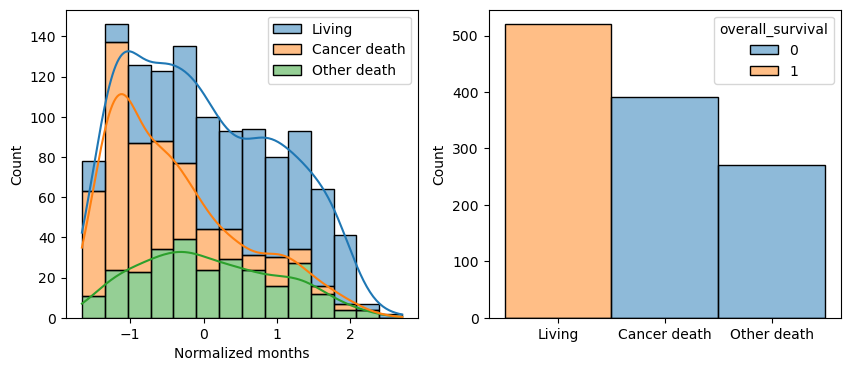

In [698]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='overall_survival_months',hue=df_death.iloc[:,0], multiple='stack',kde=True)
plt.xlabel('Normalized months')

plt.subplot(1,2,2)
#plt.bar(x = ['Cancer death','Other Death','Living'], height=df[['death_from_cancer_Died of Disease','death_from_cancer_Died of Other Causes', 'death_from_cancer_Living']].sum())
sns.histplot(data=df_death, x=df_death.iloc[:,0], hue=df['overall_survival'])

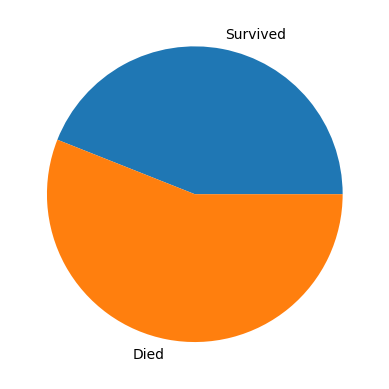

In [699]:
plt.pie(((sum(df['overall_survival']),df.shape[0]-sum(df['overall_survival']))),labels=['Survived','Died']);

### Age

<Axes: xlabel='age_at_diagnosis', ylabel='Count'>

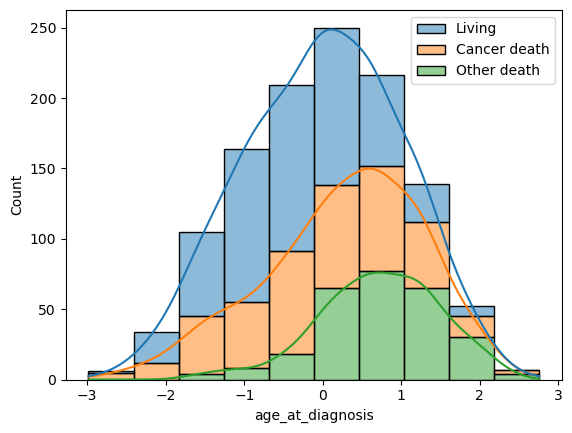

In [700]:
sns.histplot(data=df, x='age_at_diagnosis',hue=df_death.iloc[:,0],kde=True, bins=10, multiple='stack')

### Cancer sub-type

In [701]:
df.columns[df.columns.str.contains('3')]

Index(['tp53', 'e2f3', 'stat3', 'tp53bp1', 'dll3', 'dtx3', 'ep300', 'maml3',
       'notch3', 'bmp3', 'casp3', 'diras3', 'erbb3', 'folr3', 'foxo3', 'gsk3b',
       'itgb3', 'map2k3', 'map3k1', 'map3k3', 'map3k4', 'map3k5', 'mapk3',
       'mmp13', 'mmp23b', 'mmp3', 'peg3', 'pik3ca', 'pik3r1', 'pik3r2',
       'smad3', 'tgfb3', 'tgfbr3', 'gata3', 'tbx3', 'bbc3', 'cyp3a4',
       'slco1b3', 'bcas3', 'cacna2d3', 'ccnd3', 'clk3', 'col6a3', 'ctnna3',
       'flt3', 'frmd3', 'gpr32', 'kdm3a', 'lamb3', 'map3k10', 'map3k13',
       'myo3a', 'ncoa3', 'nr3c1', 'nrg3', 'sf3b1', 'zfp36l1', 'ackr3',
       'akr1c3', 'akt3', 'cyp3a43', 'cyp3a5', 'cyp3a7', 'hsd17b13', 'hsd17b3',
       'hsd3b1', 'hsd3b2', 'hsd3b7', 'pik3r3', 'srd5a3', 'pik3ca_mut',
       'tp53_mut', 'gata3_mut', 'map3k1_mut', 'tbx3_mut', 'col6a3_mut',
       'lamb3_mut', 'sf3b1_mut', 'ep300_mut', 'erbb3_mut',
       '3-gene_classifier_subtype_ER+/HER2- High Prolif',
       '3-gene_classifier_subtype_ER+/HER2- Low Prolif',
       '3-

([<matplotlib.axis.XTick at 0x215292d10f0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

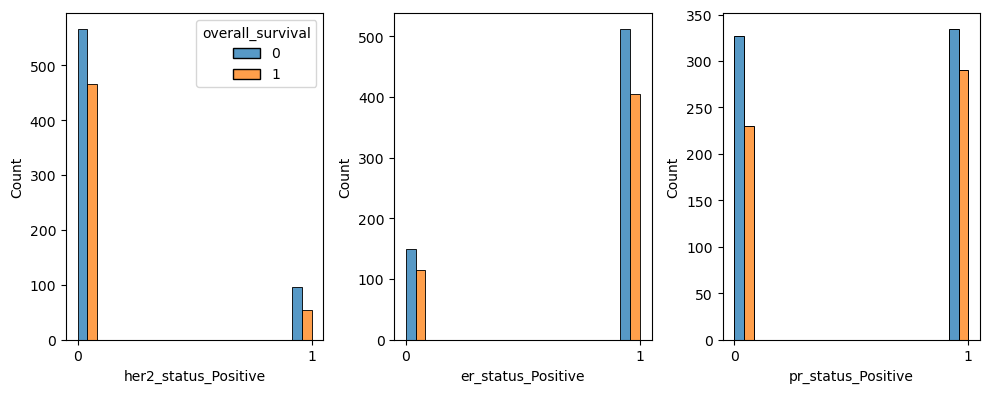

In [702]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
sns.histplot(data=df.sort_values('her2_status_Positive'), x='her2_status_Positive',hue='overall_survival',multiple='dodge')
plt.xticks((0,1))
plt.subplot(1,3,2)
sns.histplot(data=df.sort_values('er_status_Positive'), x='er_status_Positive', hue='overall_survival',multiple='dodge',legend=False)
plt.xticks((0,1))
plt.tight_layout()
plt.subplot(1,3,3)
sns.histplot(data=df.sort_values('pr_status_Positive'), x='pr_status_Positive', hue='overall_survival',multiple='dodge',legend=False)
plt.xticks((0,1))

In [703]:
df_gene = df[['3-gene_classifier_subtype_ER+/HER2- High Prolif','3-gene_classifier_subtype_ER+/HER2- Low Prolif','3-gene_classifier_subtype_ER-/HER2-','3-gene_classifier_subtype_HER2+']]
df_gene

,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
1177,0,1,0,0
1178,0,1,0,0
1179,0,0,1,0
1180,1,0,0,0


### Cancer severity


| Stage | Description |
| ----- | ---------------------------------------|
| 0 | Abnormal cells present with the potential to become cancer. |
| 1 | Cancer is only in original location and has not spread into neighboring tissue. Surgery can normaly remove the entire tumor. |
| 2 - 3 | Cancer is larger and has grown into nearby tissue or lymph nodes. |
| 4 | Advanced/metastatic cancer that has spread to other organs. |


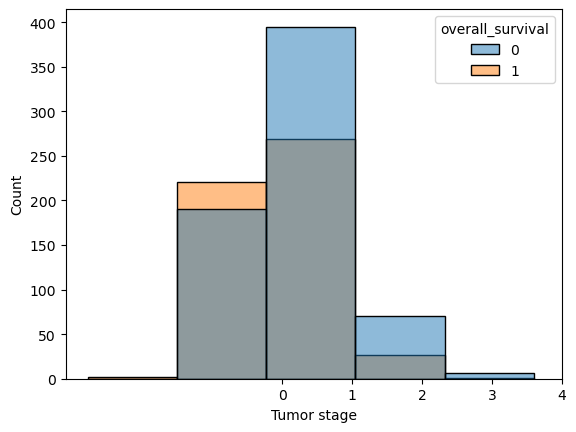

In [704]:
#histplot
sns.histplot(data=df, x='tumor_stage', bins=5, hue='overall_survival')
plt.xlabel('Tumor stage')
plt.xticks([0,1,2,3,4]);

Text(0.5, 0, 'Nottingham index')

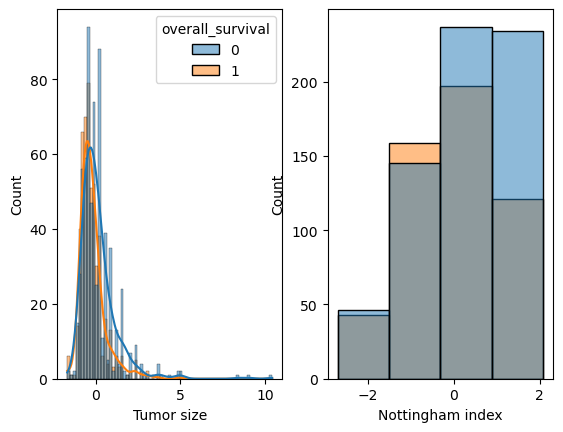

In [705]:
plt.subplot(1,2,1)
sns.histplot(data=df, x='tumor_size',hue='overall_survival', kde=True)
plt.xlabel('Tumor size')
plt.subplot(1,2,2)
sns.histplot(data=df, x='nottingham_prognostic_index',hue='overall_survival',bins=4,legend=False)
plt.xlabel('Nottingham index')

### Feature correlation to patient mortality

In [706]:
print('Top 15 features correlated with death:')
df.corr(numeric_only=True)['overall_survival'].sort_values()[:15]

Top 15 features correlated with death:


death_from_cancer_Died of Disease        -0.623122
death_from_cancer_Died of Other Causes   -0.483391
age_at_diagnosis                         -0.309256
cohort_3.0                               -0.210642
tumor_size                               -0.170795
ncoa3                                    -0.169430
type_of_breast_surgery_MASTECTOMY        -0.169163
lymph_nodes_examined_positive            -0.168063
tumor_stage                              -0.167757
gsk3b                                    -0.167004
kmt2c                                    -0.154626
tsc2                                     -0.148509
nottingham_prognostic_index              -0.147213
maml1                                    -0.137035
akt1                                     -0.135464
Name: overall_survival, dtype: float64

In [707]:
print('Top 10 features correlated with survival:')
df.corr(numeric_only=True)['overall_survival'].sort_values(ascending=False)[:15]

Top 10 features correlated with survival:


overall_survival                 1.000000
death_from_cancer_Living         1.000000
overall_survival_months          0.412227
cdkn2c                           0.211885
hsd17b11                         0.207751
jak1                             0.193702
casp8                            0.187504
myc                              0.179950
lama2                            0.178204
cohort_1.0                       0.177976
inferred_menopausal_state_Pre    0.177439
spry2                            0.171490
stat5a                           0.161958
tgfbr2                           0.160153
igf1                             0.159679
Name: overall_survival, dtype: float64

## Predicting death
### Test and train sets


In [708]:
#remove other death indicators from dataset and focus on overall mortality 
del df['death_from_cancer_Died of Disease']
del df['death_from_cancer_Died of Other Causes']
del df['death_from_cancer_Living']

In [709]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train, y_train = train_set.drop(columns=['overall_survival']), train_set['overall_survival']
X_test, y_test = test_set.drop(columns=['overall_survival']), test_set['overall_survival']

### Classfication

In [982]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score,f1_score, roc_auc_score

#selecting models 
log_mod = LogisticRegression(max_iter=10000,random_state=10).fit(X_train, y_train) 
lasso_mod = LogisticRegression(max_iter=1000,penalty='l1',C=.05,solver='saga',random_state=10).fit(X_train, y_train)
elastic_mod = LogisticRegression(max_iter=10000,C=.01,penalty='elasticnet',l1_ratio=0.2,solver='saga', random_state=10).fit(X_train, y_train)
svm_mod = LinearSVC(random_state=10,max_iter=10000, C=.001).fit(X_train, y_train)
svm_kernel = SVC(kernel='sigmoid', random_state=10, max_iter=10000, gamma='scale').fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=700,random_state=10).fit(X_train,y_train)
et = ExtraTreesClassifier(n_estimators=2600, random_state=10).fit(X_train, y_train)

models = [log_mod,lasso_mod,elastic_mod,svm_mod,svm_kernel, rf, rf, et]
model_names = [type(model).__name__ for model in models]

#scoring models
accuracy = []
precision = []
f1 = []
roc_auc = []

for model in models:
    y_predict = model.predict(X_test)
    accuracy.append(accuracy_score(y_predict,y_test))
    precision.append(precision_score(y_predict, y_test))
    f1.append(f1_score(y_predict, y_test))
    roc_auc.append(roc_auc_score(y_predict, y_test))

scores = pd.DataFrame([accuracy, precision, f1, roc_auc],columns=model_names,index=['accuracy','precision','f1','roc_auc']).T

In [984]:
scores

,accuracy,precision,f1,roc_auc
LogisticRegression,0.713080,0.669811,0.676190,0.709767
LogisticRegression,0.746835,0.641509,0.693878,0.748526
LogisticRegression,0.751055,0.632075,0.694301,0.755057
LinearSVC,0.734177,0.660377,0.689655,0.732253
SVC,0.746835,0.641509,0.693878,0.748526
RandomForestClassifier,0.751055,0.584906,0.677596,0.765097
RandomForestClassifier,0.751055,0.584906,0.677596,0.765097
ExtraTreesClassifier,0.772152,0.622642,0.709677,0.785111


(0.0, 1.1)

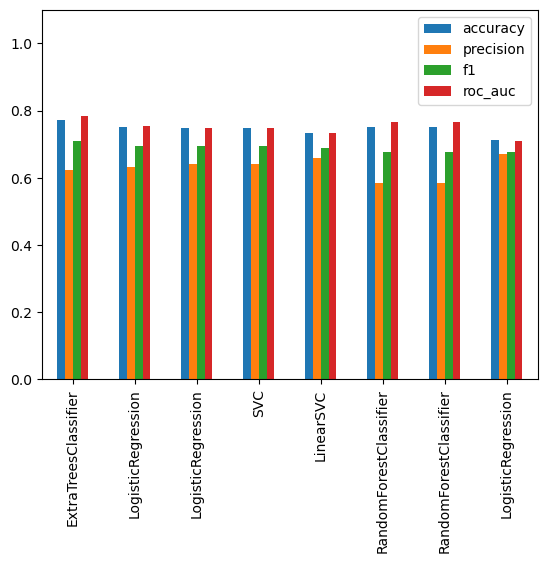

In [988]:
scores.sort_values('f1',ascending=False).plot(kind='bar')
plt.ylim((0,1.1))

In [745]:
y_proba = reg.predict_proba(X_train)
y_proba

array([[0.07957545, 0.92042455],
       [0.99484599, 0.00515401],
       [0.98677956, 0.01322044],
       ...,
       [0.16393347, 0.83606653],
       [0.99437913, 0.00562087],
       [0.73944961, 0.26055039]])

In [764]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(xb, X_train, y_train, cv=5,method='decision_function')
fpr,tpr,thresholds=roc_curve(y_train, y_scores)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

TypeError: Cannot clone object '<xgboost.core.Booster object at 0x000002153CDBFD90>' (type <class 'xgboost.core.Booster'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

Text(0, 0.5, 'True Positive Rate (Recall)')

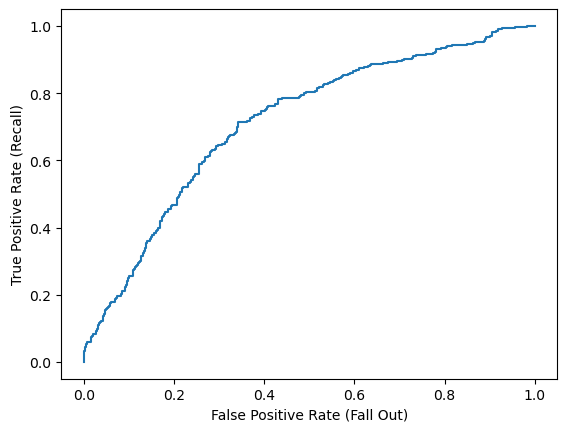

In [718]:
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate (Fall Out)')
plt.ylabel('True Positive Rate (Recall)')

Text(0.5, 0, 'Threshold')

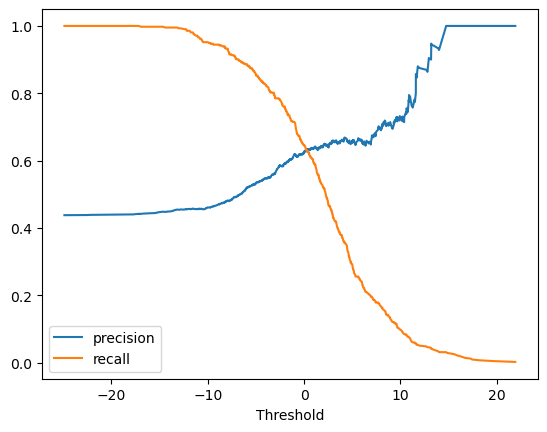

In [723]:
plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.legend()
plt.xlabel('Threshold')